In [ ]:
import seaborn as sns
import functools
import sys
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.utils.data
from PIL import Image
import transforms as T
import re
import cv2
import utils.processLiver as pl
from net.PLM import GRU_with_Attention
from dataset.dataset import SliceDataset
from utils.utils import *


def numericalize_data(targetDict, max_length = 350,dataPading = False, padidx = 4):
    DicList = []
    for key in list(targetDict.keys()):
        first = getDiseaseTypeFromName(key)
        numSeq = transNameToNum(targetDict[key])
        cl = len(numSeq)
        if cl >max_length:
            cutting_len = int((cl - max_length)/2)
            numSeq = numSeq[cutting_len:cl - cutting_len]
        lengthFlag = len(numSeq)
        if dataPading and len(numSeq)<max_length:
            numSeq += [padidx]*(max_length-len(numSeq))
        DicList.append({'name':key,'ids':numSeq,'label':first,'length':lengthFlag})
    return DicList
    
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch_name = [i['name'] for i in batch]
    batch = {'ids': batch_ids,
             'length': batch_length,
             'label': batch_label,
            'name':batch_name}
    return batch

def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

def getSegmentationOnePic(image_path,save_path,masklabel_confidence = 0.6):
    imm = Image.open(image_path)
    imm = np.array(imm)
    transforms = []
    transforms.append(T.ToTensor())
    immmm = T.Compose(transforms)(imm,target=False)
    model.eval()
    prediction = model([immmm[0].to(device)])
    labels = prediction[0]['labels']
    labels = labels.cpu().detach().numpy()
    scores = prediction[0]['scores']
    scores = scores.cpu().detach().numpy()
    masks = prediction[0]['masks']
    m1 = masks[0][0].detach().cpu()
    m1[m1>=masklabel_confidence]= int(labels[0])
    m1[m1<masklabel_confidence] = 0
    if save_path:
        imageio.imwrite(os.path.join(save_path,'segmentation.png'), m1.astype('uint8'))
    return m1

def diagnose_one_person(CT_iamge_folder,model,masklabel_confidence):
    names = {'0': 'norm', '1': 'CE','2':'AE','3':'HC'}
    lst = os.listdir(CT_iamge_folder)
    print('Current patient path',CT_iamge_folder)
    lst.sort(key=lambda l: int(re.findall('\d+',l.split('_')[-1])[0]))
    imgss = lst
    people_sli = []
    for pickOne in imgss:
        imm = Image.open(os.path.join(CT_iamge_folder,pickOne))
        imm = np.array(imm)
        transforms = []
        transforms.append(T.ToTensor())
        immmm = T.Compose(transforms)(imm,target=False)
        prediction = model([immmm[0].to(device)])
        labels = prediction[0]['labels']
        labels = labels.cpu().detach().numpy()
        scores = prediction[0]['scores']
        scores = scores.cpu().detach().numpy()
        label_idx = [i for i in range(len(scores)) if scores[i] > masklabel_confidence]
        if len(label_idx) == 0:
            name = 'norm'
        else:
            scs = scores.tolist()
            name = names.get(str(labels[scs.index(max(scs))].item()))
        people_sli.append(name)
    return people_sli

def diagnose_all_people(patients_folder,model,masklabel_confidence = 0.8):
    rootList = os.listdir(patients_folder)
    peopleDiagSequence = {}
    for rootp in rootList:
        personRoot = patients_folder + rootp
        people_slis = diagnose_one_person(os.path.join(personRoot,'liverData'),model,masklabel_confidence)
        peopleDiagSequence[rootp] = people_slis
    print('All slices are diagnosed')
    return peopleDiagSequence

def diagnosisPatient(dataloader, model, device):
    model.eval()
    seqAttn = []
    seq = []
    predicted_classes = []
    predicted_scores = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            seq.append(ids)
            length = batch['length']
            label = batch['label'].to(device)
            attenW, prediction = model(ids, length)
            attenW = attenW.squeeze(2).squeeze(0)
            seqAttn.append(attenW)
            predicted_score = prediction.cpu().squeeze(0).numpy()
            predicted_scores.append(predicted_score)
            predicted_class = int(prediction.argmax(dim=-1).squeeze(0).cpu())
        predicted_classes.append(predicted_class)
        predScores = torch.softmax(torch.tensor(predicted_scores),1)
        predScores = np.around(np.array(predScores.tolist()),3)
        for pss,pcs in zip(predScores, predicted_classes):
            print('the patient is predicted as {} with confidenct {}'.format(transNumToStandardName([pcs])[0],pss[pcs]))
    return seq,seqAttn

def show_slice_attention_map(seq,seqAttn):
    num = 0
    print('slice-attention map for this patient')
    plt.figure(figsize = ([2,2]))
    ax = sns.heatmap([np.array([0,1,2,3])],square=True,cbar = False,linewidths=0.1,cmap = 'Accent',vmax=4,vmin=0)
    ax.xaxis.tick_top()
    plt.xticks(ticks=list([0.5,1.5,2.5,3.5]),labels=['normal','CE','AE','HC'])
    plt.xticks(rotation=0)
    plt.yticks([])
    plt.figure(figsize=[20,2])
    plt.subplot(2,1,1)
    ax = sns.heatmap([seq[num].detach().cpu()[0].numpy()],square=False,cbar = False,linewidths=0.1,cmap = 'Accent',vmax=4,vmin=0)
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    plt.yticks([])
    plt.subplot(2,1,2)
    sns.heatmap([seqAttn[num].detach().cpu().numpy()],square=False,linewidths=0,cmap = 'Reds',cbar = False,)
    plt.yticks([])
    plt.xticks([])

def show_salience_segmentation(image_path,liverPred_path): 
    dataSlice = np.array(Image.open(image_path))
    liverPred = np.array(Image.open(liverPred_path))
    slice_lesion_segmentation = getSegmentationOnePic(image_path,save_path=None)
    #检测所有图形的轮廓
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(wspace = 0.03, hspace =0) ## 子图间距
    img_cv = np.array(np2cv2(dataSlice),'uint8')
    color=(54, 115, 104)
    color2=hex2rgb(0xBDD2B6)
    color_tumor = hex2rgb(0xFFAB4C)
    alpha = 0.4
    contours_tumor_ground = getContour(np.array(Image.open(image_path)))
    contours_liver_pred = getContour(liverPred)
    contours_tumor_pred = getContour(slice_lesion_segmentation)
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(dataSlice,cmap = 'gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    dst = img_cv.copy()
    # cv2.drawContours(dst, contours, -1, color, -1)
    cv2.drawContours(dst, contours_tumor_pred, -1, color_tumor, -1)
    tmp_dst = dst.copy()
    dst = img_cv.copy()
    dst1 = cv2.addWeighted(dst,alpha,tmp_dst,1-alpha,0)
    cv2.drawContours(dst1, contours_liver_pred, -1, color2, 2)
    plt.imshow(dst1)

In [ ]:
### load slice-level model
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4
model = get_instance_segmentation_model(num_classes)
save = torch.load('model/pretrained/slice-level-prediction.pth') 
model.load_state_dict(save['model'])
md = model.to(device)
me = model.eval()

In [ ]:
pl.extractLiver_OnePerson('data-input/patient-example/CE144.nii','results/liver-segmentation/CE144_pred.nii.gz','results/extracted-liver/','CE144')

In [ ]:
test_path = 'results/extracted-liver/'
testExample = diagnose_all_people(test_path,model,masklabel_confidence=0.6)
# with open("testDictexample.pkl", "wb") as tf:
#     pickle.dump(testExample,tf,protocol=pickle.HIGHEST_PROTOCOL)

Current patient path results/extracted-liver/CE144/liverData
All slices are diagnosed


In [11]:
### load GRU model
maxLen = 230
vocab_size = 5
embedding_dim = 5 
hidden_dim = 50
output_dim = 4
n_layers = 1
bidirectional = True
dropout_rate = 0
pad_index = 4

# with open("testDictexample.pkl", "rb") as tf:
#     testExampleSeq = pickle.load(tf)

testExampleSeq = testExample
modelGRU_atten = GRU_with_Attention(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, 
             pad_index = pad_index)
save = torch.load('module/pretrained/patient-level-diagnosis.pt',map_location=torch.device('cpu')) 
deviceInfer = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
modelGRU_atten.load_state_dict(save)
modelGRU_atten.to(deviceInfer)
modelGRU_atten.eval()
collate = functools.partial(collate, pad_index=pad_index)
### test data
testDicList = numericalize_data(testExampleSeq,max_length=maxLen,dataPading=False)
test_data = SliceDataset(testDicList)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, collate_fn=collate,shuffle = False)
seq,seqAttn = diagnosisPatient(test_dataloader,modelGRU_atten,deviceInfer)

evaluating...: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 206.84it/s]
the patient is predicted as CE with confidenct 0.999


slice-attention map for this patient


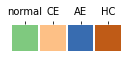

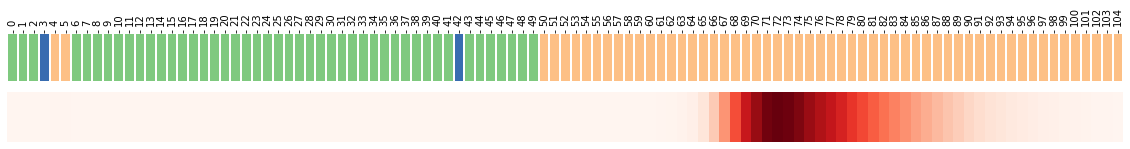

In [104]:
### slice-attention map
show_slice_attention_map(seq,seqAttn)

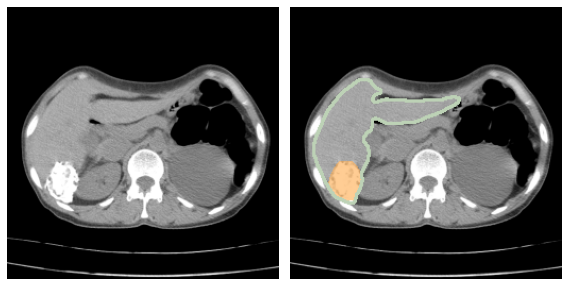

In [8]:
CT_iamge_folder = 'results/extracted-liver/CE144/liverData/'
lst = os.listdir(CT_iamge_folder)
lst.sort(key=lambda l: int(re.findall('\d+',l.split('_')[-1])[0]))
sal_idx = np.argmax(seqAttn[0].detach().cpu().numpy())
image_path = os.path.join('results/extracted-liver/CE144/liverData/',lst[sal_idx])
liverPred_path = os.path.join('results/extracted-liver/CE144/liverPredMask/',lst[sal_idx])

### show most salient slice and its lesion segmentation and liver segmentation
show_salience_segmentation(image_path,liverPred_path)